In [ ]:
#%% # Key Libraries
import abc
import logging

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import meshpy.triangle as mp
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.spatial import cKDTree
from numpy.polynomial.legendre import leggauss

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

In [11]:
class Domain:
    def __init__(self, vertices, edges):
        """
        Simple container for a 2D domain data.
        
        Args:
            vertices    : NumPy array of shape (n, 2)
            edges       : NumPy array of shape (m, 2) with vertex indices
        
        """
        self.vertices = vertices
        self.edges = edges

In [12]:
class GaussLegendreQuad:
    """
    Simple container for 2D Gauss-Legendre product quadrature data. 
    """
    
    def __init__(self, points, weights):
        """
        Args:
            points      : np.ndarray, quadrature points, shape (N, 2).
            weights     : np.ndarray, quadrature weights, shape (N,).
            
        """
        self.points = points
        self.weights = weights

In [13]:
class Dunavant:
    
    """
    A class that encapsulates the Dunavant quadrature rule for the reference triangle.
    Modified from C++ code by John Burkardt.
    
    Author : Gianluca Seaford
    Date   : 2021-03-16
    
    Reference:

        David Dunavant,
        High Degree Efficient Symmetrical Gaussian Quadrature Rules
        for the Triangle,
        International Journal for Numerical Methods in Engineering,
        Volume 21, 1985, pages 1129-1148.

        James Lyness, Dennis Jespersen,
        Moderate Degree Symmetric Quadrature Rules for the Triangle,
        Journal of the Institute of Mathematics and its Applications,
        Volume 15, Number 1, February 1975, pages 19-32.
        
        John Burkardt,
        triangle_dunavant_rule.cpp
        https://people.sc.fsu.edu/~jburkardt/cpp_src/triangle_dunavant_rule/triangle_dunavant_rule.html
        Accessed 2021-03-16.
        
    
    Attributes:
        rule      : integer, the chosen rule (from 1 to 20)
        degree    : polynomial degree of exactness (here taken equal to the rule number)
        order     : total number of quadrature points (computed from the suborder data)
        points    : NumPy array of shape (order, 2) with the quadrature points (in barycentric coordinates,
                    where we interpret the first two coordinates as the x and y of the point)
        weights   : NumPy array of length order containing the quadrature weights.
      
    """
    
    # Compressed suborder information
    _suborder = {
    1: [1],
    2: [3],
    3: [1, 3],
    4: [3, 3],
    5: [1, 3, 3],
    6: [3, 3, 6],
    7: [1, 3, 3, 6],
    8: [1, 3, 3, 3, 6],
    9: [1, 3, 3, 3, 3, 6],
    10: [1, 3, 3, 6, 6, 6],
    11: [3, 3, 3, 3, 3, 6, 6],
    12: [3, 3, 3, 3, 3, 6, 6, 6],
    13: [1, 3, 3, 3, 3, 3, 3, 6, 6, 6],
    14: [3, 3, 3, 3, 3, 3, 6, 6, 6, 6],
    15: [3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6],
    16: [1, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6],
    17: [1, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6],
    18: [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6],
    19: [1, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6],
    20: [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6]
    }
    # Compressed subrule data.
    # Each rule maps to a tuple (suborder_xyz, suborder_w), where:
    
    _subrules ={
        1: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333],
            [1.000000000000000]
        ),
        2: (
            [0.666666666666667, 0.166666666666667, 0.166666666666667],
            [0.333333333333333]
        ),
        3: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.600000000000000, 0.200000000000000, 0.200000000000000],
            [-0.562500000000000, 0.520833333333333]
        ),
        4: (
            [0.108103018168070, 0.445948490915965, 0.445948490915965,
             0.816847572980459, 0.091576213509771, 0.091576213509771],
            [0.223381589678011, 0.109951743655322]
        ),
        5: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.059715871789770, 0.470142064105115, 0.470142064105115,
             0.797426985353087, 0.101286507323456, 0.101286507323456],
            [0.225000000000000, 0.132394152788506, 0.125939180544827]
        ),
        6: (
            [0.501426509658179, 0.249286745170910, 0.249286745170910,
             0.873821971016996, 0.063089014491502, 0.063089014491502,
             0.053145049844817, 0.310352451033784, 0.636502499121399],
            [0.116786275726379, 0.050844906370207, 0.082851075618374]
        ),
        7: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.479308067841920, 0.260345966079040, 0.260345966079040,
             0.869739794195568, 0.065130102902216, 0.065130102902216,
             0.048690315425316, 0.312865496004874, 0.638444188569810],
            [-0.149570044467682, 0.175615257433208, 0.053347235608838, 
             0.077113760890257]
        ),
        8: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.081414823414554, 0.459292588292723, 0.459292588292723,
             0.658861384496480, 0.170569307751760, 0.170569307751760,
             0.898905543365938, 0.050547228317031, 0.050547228317031,
             0.008394777409958, 0.263112829634638, 0.728492392955404],
            [0.144315607677787, 0.095091634267285, 0.103217370534718,
             0.032458497623198, 0.027230314174435]
        ),
        9: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.020634961602525, 0.489682519198738, 0.489682519198738,
             0.125820817014127, 0.437089591492937, 0.437089591492937,
             0.623592928761935, 0.188203535619033, 0.188203535619033,
             0.910540973211095, 0.044729513394453, 0.044729513394453,
             0.036838412054736, 0.221962989160766, 0.741198598784498],
            [0.097135796282799, 0.031334700227139, 0.077827541004774,
             0.079647738927210, 0.025577675658698, 0.043283539377289]
        ),
        10: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.028844733232685, 0.485577633383657, 0.485577633383657,
             0.781036849029926, 0.109481575485037, 0.109481575485037,
             0.141707219414880, 0.307939838764121, 0.550352941820999,
             0.025003534762686, 0.246672560639903, 0.728323904597411,
             0.009540815400299, 0.066803251012200, 0.923655933587500],
            [0.090817990382754, 0.036725957756467, 0.045321059435528,
             0.072757916845420, 0.028327242531057, 0.009421666963733]
        ),
        11: (
            [-0.069222096541517, 0.534611048270758, 0.534611048270758,
             0.202061394068290, 0.398969302965855, 0.398969302965855,
             0.593380199137435, 0.203309900431282, 0.203309900431282,
             0.761298175434837, 0.119350912282581, 0.119350912282581,
             0.935270103777448, 0.032364948111276, 0.032364948111276,
             0.050178138310495, 0.356620648261293, 0.593201213428213,
             0.021022016536166, 0.171488980304042, 0.807489003159792],
            [0.000927006328961, 0.077149534914813, 0.059322977380774,
             0.036184540503418, 0.013659731002678, 0.052337111962204,
             0.020707659639141]
        ),
        12: (
            [0.023565220452390, 0.488217389773805, 0.488217389773805,
             0.120551215411079, 0.439724392294460, 0.439724392294460,
             0.457579229975768, 0.271210385012116, 0.271210385012116,
             0.744847708916828, 0.127576145541586, 0.127576145541586,
             0.957365299093579, 0.021317350453210, 0.021317350453210,
             0.115343494534698, 0.275713269685514, 0.608943235779788,
             0.022838332222257, 0.281325580989940, 0.695836086787803,
             0.025734050548330, 0.116251915907597, 0.858014033544073],
            [0.025731066440455, 0.043692544538038, 0.062858224217885,
             0.034796112930709, 0.006166261051559, 0.040371557766381,
             0.022356773202303, 0.017316231108659]
        ),
        13: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.009903630120591, 0.495048184939705, 0.495048184939705,
             0.062566729780852, 0.468716635109574, 0.468716635109574,
             0.170957326397447, 0.414521336801277, 0.414521336801277,
             0.541200855914337, 0.229399572042831, 0.229399572042831,
             0.771151009607340, 0.114424495196330, 0.114424495196330,
             0.950377217273082, 0.024811391363459, 0.024811391363459,
             0.094853828379579, 0.268794997058761, 0.636351174561660,
             0.018100773278807, 0.291730066734288, 0.690169159986905,
             0.022233076674090, 0.126357385491669, 0.851409537834241],
            [0.052520923400802, 0.011280145209330, 0.031423518362454,
             0.047072502504194, 0.047363586536355, 0.031167529045794,
             0.007975771465074, 0.036848402728732, 0.017401463303822,
             0.015521786839045]
        ),
        14: (
            [0.022072179275643, 0.488963910362179, 0.488963910362179,
             0.164710561319092, 0.417644719340454, 0.417644719340454,
             0.453044943382323, 0.273477528308839, 0.273477528308839,
             0.645588935174913, 0.177205532412543, 0.177205532412543,
             0.876400233818255, 0.061799883090873, 0.061799883090873,
             0.961218077502598, 0.019390961248701, 0.019390961248701,
             0.057124757403648, 0.172266687821356, 0.770608554774996,
             0.092916249356972, 0.336861459796345, 0.570222290846683,
             0.014646950055654, 0.298372882136258, 0.686980167808088,
             0.001268330932872, 0.118974497696957, 0.879757171370171],
            [0.021883581369429, 0.032788353544125, 0.051774104507292,
             0.042162588736993, 0.014433699669777, 0.004923403602400,
             0.024665753212564, 0.038571510787061, 0.014436308113534,
             0.005010228838501]
        ),
        15: (
            [-0.013945833716486, 0.506972916858243, 0.506972916858243,
             0.137187291433955, 0.431406354283023, 0.431406354283023,
             0.444612710305711, 0.277693644847144, 0.277693644847144,
             0.747070217917492, 0.126464891041254, 0.126464891041254,
             0.858383228050628, 0.070808385974686, 0.070808385974686,
             0.962069659517853, 0.018965170241073, 0.018965170241073,
             0.133734161966621, 0.261311371140087, 0.604954466893291,
             0.036366677396917, 0.388046767090269, 0.575586555512814,
            -0.010174883126571, 0.285712220049916, 0.724462663076655,
             0.036843869875878, 0.215599664072284, 0.747556466051838,
             0.012459809331199, 0.103575616576386, 0.883964574092416],
            [0.001916875642849, 0.044249027271145, 0.051186548718852,
             0.023687735870688, 0.013289775690021, 0.004748916608192,
             0.038550072599593, 0.027215814320624, 0.002182077366797,
             0.021505319847731, 0.007673942631049]
        ),
        16: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.005238916103123, 0.497380541948438, 0.497380541948438,
             0.173061122901295, 0.413469438549352, 0.413469438549352,
             0.059082801866017, 0.470458599066991, 0.470458599066991,
             0.518892500060958, 0.240553749969521, 0.240553749969521,
             0.704068411554854, 0.147965794222573, 0.147965794222573,
             0.849069624685052, 0.075465187657474, 0.075465187657474,
             0.966807194753950, 0.016596402623025, 0.016596402623025,
             0.103575692245252, 0.296555596579887, 0.599868711174861,
             0.020083411655416, 0.337723063403079, 0.642193524941505,
            -0.004341002614139, 0.204748281642812, 0.799592720971327,
             0.041941786468010, 0.189358492130623, 0.768699721401368,
             0.014317320230681, 0.085283615682657, 0.900399064086661],
            [0.046875697427642, 0.006405878578585, 0.041710296739387,
             0.026891484250064, 0.042132522761650, 0.030000266842773,
             0.014200098925024, 0.003582462351273, 0.032773147460627,
             0.015298306248441, 0.002386244192839, 0.019084792755899,
             0.006850054546542]
        ),
        17: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.005658918886452, 0.497170540556774, 0.497170540556774,
             0.035647354750751, 0.482176322624625, 0.482176322624625,
             0.099520061958437, 0.450239969020782, 0.450239969020782,
             0.199467521245206, 0.400266239377397, 0.400266239377397,
             0.495717464058095, 0.252141267970953, 0.252141267970953,
             0.675905990683077, 0.162047004658461, 0.162047004658461,
             0.848248235478508, 0.075875882260746, 0.075875882260746,
             0.968690546064356, 0.015654726967822, 0.015654726967822,
             0.010186928826919, 0.334319867363658, 0.655493203809423,
             0.135440871671036, 0.292221537796944, 0.572337590532020,
             0.054423924290583, 0.319574885423190, 0.626001190286228,
             0.012868560833637, 0.190704224192292, 0.796427214974071,
             0.067165782413524, 0.180483211648746, 0.752351005937729,
             0.014663182224828, 0.080711313679564, 0.904625504095608],
            [0.033437199290803, 0.005093415440507, 0.014670864527638,
             0.024350878353672, 0.031107550868969, 0.031257111218620,
             0.024815654339665, 0.014056073070557, 0.003194676173779,
             0.008119655318993, 0.026805742283163, 0.018459993210822,
             0.008476868534328, 0.018292796770025, 0.006665632004165]
        ),
        18: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.013310382738157, 0.493344808630921, 0.493344808630921,
             0.061578811516086, 0.469210594241957, 0.469210594241957,
             0.127437208225989, 0.436281395887006, 0.436281395887006,
             0.210307658653168, 0.394846170673416, 0.394846170673416,
             0.500410862393686, 0.249794568803157, 0.249794568803157,
             0.677135612512315, 0.161432193743843, 0.161432193743843,
             0.846803545029257, 0.076598227485371, 0.076598227485371,
             0.951495121293100, 0.024252439353450, 0.024252439353450,
             0.913707265566071, 0.043146367216965, 0.043146367216965,
             0.008430536202420, 0.358911494940944, 0.632657968856636,
             0.131186551737188, 0.294402476751957, 0.574410971510855,
             0.050203151565675, 0.325017801641814, 0.624779046792512,
             0.066329263810916, 0.184737559666046, 0.748933176523037,
             0.011996194566236, 0.218796800013321, 0.769207005420443,
             0.014858100590125, 0.101179597136408, 0.883962302273467,
            -0.035222015287949, 0.020874755282586, 1.014347260005363],
            [0.030809939937647, 0.009072436679404, 0.018761316939594,
             0.019441097985477, 0.027753948610810, 0.032256225351457,
             0.025074032616922, 0.015271927971832, 0.006793922022963,
            -0.002223098729920, 0.006331914076406, 0.027257538049138,
             0.017676785649465, 0.018379484638070, 0.008104732808192,
             0.007634129070725, 0.000046187660794]
        ),
        19: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
             0.020780025853987, 0.489609987073006, 0.489609987073006,
             0.090926214604215, 0.454536892697893, 0.454536892697893,
             0.197166638701138, 0.401416680649431, 0.401416680649431,
             0.488896691193805, 0.255551654403098, 0.255551654403098,
             0.645844115695741, 0.177077942152130, 0.177077942152130,
             0.779877893544096, 0.110061053227952, 0.110061053227952,
             0.888942751496321, 0.055528624251840, 0.055528624251840,
             0.974756272445543, 0.012621863777229, 0.012621863777229,
             0.003611417848412, 0.395754787356943, 0.600633794794645,
             0.134466754530780, 0.307929983880436, 0.557603261588784,
             0.014446025776115, 0.264566948406520, 0.720987025817365,
             0.046933578838178, 0.358539352205951, 0.594527068955871,
             0.002861120350567, 0.157807405968595, 0.839331473680839,
             0.223861424097916, 0.075050596975911, 0.701087978926173,
             0.034647074816760, 0.142421601113383, 0.822931324069857,
             0.010161119296278, 0.065494628082938, 0.924344252620784],
            [0.032906331388919, 0.010330731891272, 0.022387247263016,
             0.030266125869468, 0.030490967802198, 0.024159212741641,
             0.016050803586801, 0.008084580261784, 0.002079362027485,
             0.003884876904981, 0.025574160612022, 0.008880903573338,
             0.016124546761731, 0.002491941817491, 0.018242840118951,
             0.010258563736199, 0.003799928855302]
        ),
        20: (
            [0.333333333333333, 0.333333333333333, 0.333333333333333,
            -0.001900928704400, 0.500950464352200, 0.500950464352200,
             0.023574084130543, 0.488212957934729, 0.488212957934729,
             0.089726636099435, 0.455136681950283, 0.455136681950283,
             0.196007481363421, 0.401996259318289, 0.401996259318289,
             0.488214180481157, 0.255892909759421, 0.255892909759421,
             0.647023488009788, 0.176488255995106, 0.176488255995106,
             0.791658289326483, 0.104170855336758, 0.104170855336758,
             0.893862072318140, 0.053068963840930, 0.053068963840930,
             0.916762569607942, 0.041618715196029, 0.041618715196029,
             0.976836157186356, 0.011581921406822, 0.011581921406822,
             0.048741583664839, 0.344855770229001, 0.606402646106160,
             0.006314115948605, 0.377843269594854, 0.615842614456541,
             0.134316520547348, 0.306635479062357, 0.559048000390295,
             0.013973893962392, 0.249419362774742, 0.736606743262866,
             0.075549132909764, 0.212775724802802, 0.711675142287434,
            -0.008368153208227, 0.146965436053239, 0.861402717154987,
             0.026686063258714, 0.137726978828923, 0.835586957912363,
             0.010547719294141, 0.059696109149007, 0.929756171556853],
            [0.033057055541624, 0.000867019185663, 0.011660052716448,
             0.022876936356421, 0.030448982673938, 0.030624891725355,
             0.024368057676800, 0.015997432032024, 0.007698301815602,
            -0.000632060497488, 0.001751134301193, 0.016465839189576,
             0.004839033540485, 0.025804906534650, 0.008471091054441,
             0.018354914106280, 0.000704404677908, 0.010112684927462,
             0.003573909385950]
        )
    }
    
    def __init__(self, rule):
        """
        Initialise Dunavant quadrature rule.
        
        Args:
          rule (int): Rule index (must be between 1 and 20).
        """
        if not (1 <= rule <= 20):
            raise ValueError(f"Rule must be between 1 and 20; got {rule}.")
        
        self.rule = rule
        self.degree = self._compute_degree(rule)
        self.order = self._compute_order(rule)
        self.points, self.weights = self._compute_rule(rule)
        
    @staticmethod
    def _compute_degree(rule):
        return rule
    
    @classmethod
    def _compute_order(cls, rule):
        
        if rule not in cls._suborder:
            raise ValueError(f"Suborder data for rule {rule} not available.")
        
        return sum(cls._suborder[rule])
    
    @classmethod
    def _compute_rule(cls, rule):
        """
        Expand compressed subrule data into full quadrature points and weights.
        Returns:
          xy (ndarray): Array of shape (order, 2) containing quadrature points.
          w (ndarray): Array of length order with the weights.
        """
        if rule not in cls._suborder or rule not in cls._subrules:
            raise ValueError(f"Data for rule {rule} is not available.")
        
        suborder = cls._suborder[rule]
        suborder_xyz, suborder_w = cls._subrules[rule]
        
        suborder_num = len(suborder)
        total_order = sum(suborder)
        
        xy = np.zeros((total_order, 2))
        w = np.zeros(total_order)
        
        o = 0
        for s in range(suborder_num):
            if suborder[s] == 1:
                xy[o, 0] = suborder_xyz[3*s + 0]
                xy[o, 1] = suborder_xyz[3*s + 1]
                w[o] = suborder_w[s]
                o += 1
                
            elif suborder[s] == 3:
                for k in range(3):
                    idx = 3 * s + (k % 3)
                    idx_next = 3 * s + ((k + 1) % 3)
                    xy[o, 0] = suborder_xyz[idx]
                    xy[o, 1] = suborder_xyz[idx_next]
                    w[o] = suborder_w[s]
                    o += 1
                    
            elif suborder[s] == 6:
                # First set of 3 points.
                for k in range(3):
                    idx = 3 * s + (k % 3)
                    idx_next = 3 * s + ((k + 1) % 3)
                    xy[o, 0] = suborder_xyz[idx]
                    xy[o, 1] = suborder_xyz[idx_next]
                    w[o] = suborder_w[s]
                    o += 1
                    
                # Second set: reverse order.
                for k in range(3):
                    idx = 3 * s + ((k + 1) % 3)
                    idx_next = 3 * s + (k % 3)
                    xy[o, 0] = suborder_xyz[idx]
                    xy[o, 1] = suborder_xyz[idx_next]
                    w[o] = suborder_w[s]
                    o += 1
            else:
                raise ValueError(f"Illegal suborder value {suborder[s]} for rule {rule}.")
            
        return xy, w

In [14]:
class BaseMesh(abc.ABC):
    """
    Abstract base class for mesh objects.
    
    Each mesh class should implement:
      - generate_mesh()
      - shape_funcs()
      - element_stiffness()
      - get_nodes_on_edge()
      - get_default_quadrature()
      - refine_mesh()
    """
    
    def __init__(self, domain):
        
        self.domain = domain
        self.mesh = None
        self.nodes = None
        self.mesh_elements = None

    @abc.abstractmethod
    def generate_mesh(self, max_vol):
        """
        Generate a mesh, storing self.nodes and self.mesh_elements.
        """
        pass

    @abc.abstractmethod
    def shape_funcs(self, xi, eta):
        """
        Return shape functions N and local derivatives dN for a single element 
        in local coordinates (xi, eta).
        """
        pass
    
    @abc.abstractmethod
    def compute_B_matrix(self, elem_idx, xi, eta):
        """
        Compute the B matrix for the element with index elem_idx.
        """
        pass

    @abc.abstractmethod
    def element_stiffness(self, elem_idx, plane_thickness, E, nu, nodes, mesh_elements):
        """
        Compute the local stiffness matrix for the element with index elem_idx.
        """
        pass

    @abc.abstractmethod
    def get_nodes_on_edge(self, pt1, pt2, tol=1e-6):
        """
        Given two points in global coords, find which nodes lie on that line segment.
        """
        pass

    @abc.abstractmethod
    def get_quadrature(self, order):
        """
        Return a relevant quadrature rule of given order.
        """
        pass

    @abc.abstractmethod
    def refine_mesh(self, refinement_points):
        """
        Refine the mesh by adding new points or adjusting the mesh structure.
        """
        pass

In [15]:
class TriMesh(BaseMesh):
    """
    Triangular mesh implementation using meshpy.triangle.
    """
    
    def __init__(self, domain, max_volume):
        
        super().__init__(domain)
        self.max_volume = max_volume

    
    def generate_mesh(self, max_vol):
        """
        Build a triangular mesh using meshpy.triangle.
        """
        
        if max_vol is None:
            max_vol = self.max_volume

        vertices = self.domain.vertices
        segments = self.domain.edges.tolist()
        
        mesh_info = mp.MeshInfo()
        mesh_info.set_points(vertices.tolist())
        mesh_info.set_facets(segments)
        
        # Try to construct mesh using meshpy
        try:
            self.mesh = mp.build(mesh_info, max_volume=max_vol)
            
        except Exception as e:
            logging.error(f"Mesh generation failed for TriMesh: {e}")
            raise

        self.nodes = np.array(self.mesh.points)
        self.mesh_elements = np.array(self.mesh.elements, dtype=int)
        
    def shape_funcs(self, xi, eta):
        """
        Return shape functions (N) and their local derivatives (dN) for a linear triangular element.
        """
        N = np.array([xi, eta, 1 - xi - eta])
        
        dN = np.array([[1,  0],
                       [0,  1],
                       [-1, -1]])
        return N, dN
    
    def compute_B_matrix(self, elem_idx, xi, eta):
        """
        Build and return the strain-displacement (B) matrix at local coordinates (xi, eta).
        """
        nodes_idx = self.mesh_elements[elem_idx]
        coords = self.nodes[nodes_idx, :]
        
        N, dN = self.shape_funcs(xi, eta)
                
        # Jacobian matrix
        J = dN.T @ coords
                
        detJ = np.linalg.det(J)
        if abs(detJ) < 1e-14:
            logging.warning(f"Near-singular Jacobian in element {elem_idx} at xi={xi}, eta={eta}.")
                
        try:
            invJ = np.linalg.inv(J)
                    
        except np.linalg.LinAlgError as e:
            logging.error(f"Singular Jacobian in QuadMesh element {elem_idx}: {e}")
            raise ValueError(f"Singular Jacobian in element {elem_idx}.")
                
        dN_global = dN @ invJ
                
        # B matrix
        B = np.zeros((3, 6))
                
        B[0, 0::2] = dN_global[:, 0]
        B[1, 1::2] = dN_global[:, 1]
        B[2, 0::2] = dN_global[:, 1]
        B[2, 1::2] = dN_global[:, 0]
        
        return B, detJ
        

    def element_stiffness(self, elem_idx, plane_thickness, E, nu, nodes, mesh_elements):
        """
        Compute the local stiffness matrix K_e for the triangular element with index elem_idx.
        """
        
        # 2D plane stress constitutive matrix
        D = E/(1 - nu**2) * np.array([
            [1,   nu,      0],
            [nu,  1,       0],
            [0,   0, (1 - nu)/2]
        ])
        
        quad_rule = self.get_quadrature(order=4)  
        
        K_e = np.zeros((6, 6))
        
        
        for i, (xi, eta) in enumerate(quad_rule.points):
            
            w = quad_rule.weights[i]
            
            B, detJ = self.compute_B_matrix(elem_idx, xi, eta)
            
            K_e += w * abs(detJ) * (B.T @ D @ B)

        # Multiply by thickness
        K_e *= plane_thickness
        
        return K_e

    def get_nodes_on_edge(self, pt1, pt2, tol=1e-6):
        """
        Find all nodes that lie on the line segment from pt1 to pt2 (in global coords).
        Return sorted list of node indices.
        """
        vec = pt2 - pt1
        norm_sq = np.dot(vec, vec)
        nodes_on_edge = []
        
        for i, pt in enumerate(self.nodes):
            t = np.dot(pt - pt1, vec) / norm_sq
            
            if -tol <= t <= 1 + tol:
                proj = pt1 + t * vec
                
                if np.linalg.norm(pt - proj) < tol:
                    dist_pt = np.linalg.norm(pt - pt1)
                    nodes_on_edge.append((i, dist_pt))
        
        # Sort by distance from pt1
        nodes_on_edge.sort(key=lambda x: x[1])
        
        return [idx for (idx, _) in nodes_on_edge]
    
    def get_quadrature(self, order):
        """
        Return  Dunavant quadrature data for rule 'order'. 
        """
        
        if order < 1 or order > 20:
            logging.error(f"Invalid Dunavant quadrature rule passed to get_quadrature : {rule}. Rule must be between 1 and 20.")
            raise ValueError(f"Dunavant rule must be between 1 and 20, got {rule}.")
            
        return Dunavant(rule=order)
    
    def refine_mesh(self, refinement_points = None, tol=1e-6):
        """
        Refine the triangular mesh by inserting the given points into the domain vertices.
        
        Args:
            refinement_points : list of 2D coordinates
            tol               : float, tolerance for checking existing proximity
        """
        if refinement_points is None:
            logging.info("No refinement points provided, skipping refine_mesh.")
            return
        
        old_vertices = self.domain.vertices
        new_pts = []
        
        for pt in refinement_points:
            pt_arr = np.array(pt)
            
            # Check if this point is already in the domain within 'tol'
            dist = np.linalg.norm(old_vertices - pt_arr, axis=1)
            if np.all(dist > tol):
                new_pts.append(pt_arr)
        
        if new_pts:
            new_pts_arr = np.array(new_pts)
            self.domain.vertices = np.vstack([old_vertices, new_pts_arr])
            
        else:
            logging.info("No new points passed the tolerance check; skipping refinement.")

In [16]:
class QuadMesh(BaseMesh):
    """
    Quadrilateral mesh implementation for a convex quadrilateral domain.
    Each element is a 4-node bilinear quad, subdividing the domain Nx by Ny.
    """
    
    def __init__(self, domain, Nx, Ny):
        
        super().__init__(domain)
        self.Nx = Nx
        self.Ny = Ny
        
    def generate_mesh(self, max_vol=None):
        """
        Build a structured quadrilateral mesh by bilinear interpolation 
        from domain corners.
        
        Args:
            max_volume : float, optional, Currently unused, but kept for consistency with other mesh classes.
        """
        
        if len(self.domain.vertices) != 4:
            
            logging.error("QuadMesh requires exactly 4 domain vertices in CCW order.")
            raise ValueError("Domain must have exactly 4 vertices for QuadMesh.")
        
        # Extract domain corners in CCW order
        A = self.domain.vertices[0]
        B = self.domain.vertices[1]
        C = self.domain.vertices[2]
        D = self.domain.vertices[3]

        node_coords = []
        
        for j in range(self.Ny+1):
            v = j / self.Ny
            for i in range(self.Nx+1):
                u = i / self.Nx
                
                # Bilinear interpolation
                X = (1 - u)*(1 - v)*A \
                    + u*(1 - v)*B \
                    + u*v*C \
                    + (1 - u)*v*D
                node_coords.append(X)

        node_coords = np.array(node_coords)
        self.nodes = node_coords

        # Build element connectivity
        elements = []
        for j in range(self.Ny):
            for i in range(self.Nx):
                n0 = j*(self.Nx+1) + i
                n1 = j*(self.Nx+1) + (i+1)
                n2 = (j+1)*(self.Nx+1) + (i+1)
                n3 = (j+1)*(self.Nx+1) + i
                elements.append([n0, n1, n2, n3])

        self.mesh_elements = np.array(elements, dtype=int)
        
        logging.info(f"QuadMesh generated with {self.Nx} x {self.Ny} elements. "
                     f"Total nodes: {self.nodes.shape[0]}. "
                     f"Total elements: {self.mesh_elements.shape[0]}.")
        
    def shape_funcs(self, xi, eta):
        """
        Bilinear shape functions for a 4-node quad in local coords (xi, eta),
        each in [-1, +1].
        
        Returns:
            N : np.ndarray, shape (4,)
                The shape functions at (xi, eta).
            dN : np.ndarray, shape (4, 2)
                The derivatives of shape functions wrt (xi, eta).
        """
        N = np.array([0.25*(1 - xi)*(1 - eta), 
                      0.25*(1 + xi)*(1 - eta),
                      0.25*(1 + xi)*(1 + eta), 
                      0.25*(1 - xi)*(1 + eta)])

        dN = np.array([
            [-0.25*(1 - eta), -0.25*(1 - xi)],
            [ 0.25*(1 - eta), -0.25*(1 + xi)],
            [ 0.25*(1 + eta),  0.25*(1 + xi)],
            [-0.25*(1 + eta),  0.25*(1 - xi)],
        ])

        return N, dN
    
    def compute_B_matrix(self, elem_idx, xi, eta):
        """
        Build and return the strain-displacement (B) matrix for the quadrilateral element.
        """
        nodes_idx = self.mesh_elements[elem_idx]
        coords = self.nodes[nodes_idx, :]
        
        N, dN = self.shape_funcs(xi, eta)
                
        # Jacobian matrix
        J = dN.T @ coords
                
        detJ = np.linalg.det(J)
        if abs(detJ) < 1e-14:
            logging.warning(f"Near-singular Jacobian in element {elem_idx} at xi={xi}, eta={eta}.")
                
        try:
            invJ = np.linalg.inv(J)
                    
        except np.linalg.LinAlgError as e:
            logging.error(f"Singular Jacobian in QuadMesh element {elem_idx}: {e}")
            raise ValueError(f"Singular Jacobian in element {elem_idx}.")
                
        dN_global = dN @ invJ
                
        # B matrix
        B = np.zeros((3, 8))
                
        B[0, 0::2] = dN_global[:, 0]
        B[1, 1::2] = dN_global[:, 1]
        B[2, 0::2] = dN_global[:, 1]
        B[2, 1::2] = dN_global[:, 0]
        
        return B, detJ
        
    
    def element_stiffness(self, elem_idx, plane_thickness, E, nu, nodes, mesh_elements):
        """
        Compute the local stiffness matrix K_e for the bilinear quad #elem_idx,
        using 2×2 Gauss–Legendre integration over xi,eta in [-1,+1].

        Returns:
            K_e : np.ndarray, Local stiffness matrix.
        """
        
        elem_nodes = mesh_elements[elem_idx]
        coords = nodes[elem_nodes]
        
        D = E / (1 - nu**2) * np.array([
                                        [1,   nu,          0],
                                        [nu,  1,           0],
                                        [0,   0,  (1 - nu)/2]
                                        ])
        
        K_e = np.zeros((8, 8))
        
        points, weights = leggauss(3)
        
        for i, xi in enumerate(points):
            for j, eta in enumerate(points):
                
                B, detJ = self.compute_B_matrix(elem_idx, xi, eta)
                
                K_e += weights[i] * weights[j] * abs(detJ) * (B.T @ D @ B) * plane_thickness
                
        return K_e
    
    def get_nodes_on_edge(self, pt1, pt2, tol=1e-6):
        """
        Find all nodes that lie on the line segment from pt1 to pt2 (in global coords).
        
        Returns:
            A sorted list of node indices (sorted by distance from pt1).
        """
        
        vec = pt2 - pt1
        norm_sq = np.dot(vec, vec)
        nodes_on_edge = []
        
        for i, pt in enumerate(self.nodes):
            t = np.dot(pt - pt1, vec) / norm_sq
            if 0 - tol <= t <= 1 + tol:
                proj = pt1 + t*vec
                
                if np.linalg.norm(pt - proj) < tol:
                    dist_pt = np.linalg.norm(pt - pt1)
                    nodes_on_edge.append((i, dist_pt))
                    
        nodes_on_edge.sort(key=lambda x: x[1])
        
        return [idx for (idx, _) in nodes_on_edge]
    
    def get_quadrature(self, order):
        """
        Return a product Gauss–Legendre quadrature of given order for quadrilaterals.
        """
        
        points_1D, weights_1D = leggauss(order)
        
        quad_points = []
        quad_weights = []
        
        for i, xi in enumerate(points_1D):
            for j, eta in enumerate(points_1D):
                quad_points.append([xi, eta])
                quad_weights.append(weights_1D[i] * weights_1D[j])
                
        return GaussLegendreQuad(np.array(quad_points), np.array(quad_weights))

    def refine_mesh(self, refinement_points=None, tol=1e-6):
        """
        Refine the quadrilateral mesh by inserting the given points into the domain vertices.
        Currently a W.I.P.

        Args:
            refinement_points : list of 2D coordinates
            tol              : float, tolerance for checking existing proximity
        """
        
        if refinement_points is None:
            logging.info("No refinement points provided, skipping refine_mesh for QuadMesh.")
            return
        
        old_vertices = self.domain.vertices
        new_pts = []
        
        for pt in refinement_points:
            pt_arr = np.array(pt)
            dist = np.linalg.norm(old_vertices - pt_arr, axis=1)
            
            if np.all(dist > tol):
                new_pts.append(pt_arr)
        
        if new_pts:
            new_pts_arr = np.array(new_pts)
            self.domain.vertices = np.vstack([old_vertices, new_pts_arr])
            
            logging.info(f"Added {len(new_pts_arr)} new points to domain vertices for QuadMesh refinement.")
        else:
            logging.info("No new points passed the tolerance check; skipping refinement.")
            
        

In [17]:
class FiniteElement:
    """
    Main Finite Element solver class that uses either TriMesh or QuadMesh, but can be extended to additional configs.
    Handles system assembly, boundary conditions, solution, and adaptive refinement.
    """
    def __init__(self, mesh_type):
        """
        Args:
            mesh_type : str, either 'triangular' or 'quadrilateral'
        """
        
        self.mesh_type = mesh_type
        
        # Material properties
        self.Youngs_modulus = None
        self.Poisson_ratio = None
        self.plane_thickness = None
        
        # System properties
        self.domain = None
        self.tractions = None
        self.forces = None

        # Mesh properties      
        self.mesh_obj = None  
        self.mesh = None
        self.nodes = None
        self.mesh_elements = None
        self.max_volume = None
        
        # System Matrices
        self.K = None
        self.F = None
        self.U = None
        
        # Stress and Strain Fields
        self.Stress = None
        self.Strain = None
        
        # Reference Solutions
        self.ref_mesh_obj = None 
        self.ref_nodes = None
        self.ref_mesh_elements = None
        self.K_ref = None
        self.F_ref = None
        self.U_ref = None
        self.Stress_ref = None
        self.Strain_ref = None
        
        # Refinement History (mean relative error and element count)
        self.num_element_history = []
        self.error_history = []
        
    @property
    def num_nodes(self):
        return self.nodes.shape[0]
    
    @property
    def ref_num_nodes(self):
        return self.ref_nodes.shape[0]
    
    @property
    def num_elements(self):
        return self.mesh_elements.shape[0]
    
    @property
    def ref_num_elements(self):
        return self.ref_mesh_elements.shape[0]
    
    def _set_system_params(self, domain, E, nu, thickness, tractions=None, forces=None, init_vol=None, Nx=None, Ny=None):
        """
        Set up the domain, mesh parameters, and material properties.
        """
        
        self.domain = domain
        self.tractions = tractions
        self.forces = forces
        self.Youngs_modulus = E
        self.Poisson_ratio = nu
        self.plane_thickness = thickness
        
        self.max_volume = init_vol
        self.Nx = Nx
        self.Ny = Ny
        
        if self.mesh_type == 'triangular':
            if self.max_volume is None:
                logging.error("Max volume must be specified for triangular mesh.")
                raise ValueError("Max volume must be specified for triangular mesh.")
            
            self.mesh_obj = TriMesh(self.domain, max_volume=self.max_volume)
        
        elif self.mesh_type == 'quadrilateral':
            if Nx is None or Ny is None:
                logging.error("Nx, Ny must be specified for quadrilateral mesh.")
                raise ValueError("Nx, Ny must be specified for quadrilateral mesh.")
            
            self.mesh_obj = QuadMesh(self.domain, Nx=self.Nx, Ny=self.Ny)
            
        else: 
            logging.error(f"Mesh type {self.mesh_type} not recognised.")
            raise ValueError(f"Mesh type {self.mesh_type} not recognised.")
        
        
    def _generate_mesh(self, max_volume=0.15):
        """
        Wrapper to call mesh generation method from the mesh object.
        """
        
        self.mesh_obj.generate_mesh(max_volume)
        
        self.mesh = self.mesh_obj.mesh
        self.nodes = self.mesh_obj.nodes
        self.mesh_elements = self.mesh_obj.mesh_elements
    
    def _constitutive_matrix(self):
        
        E = self.Youngs_modulus
        nu = self.Poisson_ratio
        
        return E / (1 - nu**2) * np.array([[  1, nu,          0],
                                           [ nu,  1,          0],
                                           [  0,  0, (1 - nu)/2]])
        
    def _element_stiffness(self, elem_idx):
        """
        Wrapper for computing element stiffness from the mesh object.
        """
        
        return self.mesh_obj.element_stiffness(elem_idx, self.plane_thickness, self.Youngs_modulus, 
                                               self.Poisson_ratio, self.nodes, self.mesh_elements)
        
    def _element_stiffness_ref(self, elem_idx):
        """
        Exactly like _element_stiffness, but uses the reference mesh object 
        and reference arrays.
        """
        # 2D plane stress
        E = self.Youngs_modulus
        nu = self.Poisson_ratio
        D = E / (1 - nu**2) * np.array([[  1, nu,          0],
                                        [ nu,  1,          0],
                                        [  0,  0, (1 - nu)/2]])
        
        # Use reference mesh object
        B, detJ = self.ref_mesh_obj.compute_B_matrix(elem_idx, xi=0.5, eta=0.5)
    
        # Evaluate at centroid, same as main code
        
        if self.mesh_type == 'triangular':
            return self.plane_thickness * (B.T @ D @ B) * 0.5 * abs(detJ)
        
        elif self.mesh_type == 'quadrilateral':
            return self.plane_thickness * (B.T @ D @ B) * abs(detJ)
        
        else:
            logging.error(f"Mesh type {self.mesh_type} not recognised.")
            raise ValueError(f"Mesh type {self.mesh_type} not recognised.")
    
    def _assemble_global_stiffness(self):
        """
        Assemble the global stiffness matrix in sparse COO format and convert to CSR.
        """
        
        n_nodes_elem = self.mesh_elements.shape[1]
        n_dof = 2 * self.num_nodes
        n_dof_elem = 2 * n_nodes_elem
        
        num_entries = self.num_elements * (n_dof_elem * n_dof_elem)

        # Preallocate arrays to hold row indices, column indices, and stiffness values.
        rows = np.empty(num_entries, dtype=int)
        cols = np.empty(num_entries, dtype=int)
        data = np.empty(num_entries)

        entry = 0
        for elem_idx in range(self.num_elements):
            K_e = self._element_stiffness(elem_idx)
            nodes_idx = self.mesh_elements[elem_idx]
            
            # Get DOF indices for the current element.
            dof_indices = []
            for n in nodes_idx:
                dof_indices.extend([2 * n, 2 * n + 1])
                
            # Loop over the element stiffness matrix and store indices and values.
            for i in range(n_dof_elem):
                for j in range(n_dof_elem):
                    rows[entry] = dof_indices[i]
                    cols[entry] = dof_indices[j]
                    data[entry] = K_e[i, j]
                    entry += 1

        # Create a COO-format sparse matrix and convert to CSR.
        K_coo = sp.coo_matrix((data[:entry], (rows[:entry], cols[:entry])), shape=(n_dof, n_dof))
        self.K = K_coo.tocsr()
        
    def _assemble_reference_stiffness(self):
        """
        Assemble the reference stiffness matrix K_ref in sparse format
        using self.ref_mesh_obj, self.ref_nodes, self.ref_mesh_elements, etc.
        """
        
        n_nodes_elem = self.ref_mesh_elements.shape[1]
        n_dof_ref = 2 * self.ref_nodes.shape[0]
        n_dof_elem = 2 * n_nodes_elem
    
        num_entries = self.ref_mesh_elements.shape[0]* (n_dof_elem * n_dof_elem)
        
        # Preallocate arrays to hold row indices, column indices, and stiffness values.
        rows = np.empty(num_entries, dtype=int)
        cols = np.empty(num_entries, dtype=int)
        data = np.empty(num_entries)
    
        entry = 0
        for elem_idx in range(self.ref_mesh_elements.shape[0]):
            K_e = self._element_stiffness_ref(elem_idx)  # see below
            nodes_idx = self.ref_mesh_elements[elem_idx]
        
            # Get DOF indices for the current element.
            dof_indices = []
            for n in nodes_idx:
                dof_indices.extend([2*n, 2*n+1])
        
            # Loop over the element stiffness matrix and store indices and values.
            for i in range(n_dof_elem):
                for j in range(n_dof_elem):
                    rows[entry] = dof_indices[i]
                    cols[entry] = dof_indices[j]
                    data[entry] = K_e[i,j]
                    entry += 1
    
        K_coo = sp.coo_matrix((data[:entry], (rows[:entry], cols[:entry])), shape=(n_dof_ref, n_dof_ref))
        
        self.K_ref = K_coo.tocsr()
        
        
    def _get_nodes_on_edge(self, pt1, pt2, tol=1e-6):
        """
        Wrapper to obtain sorted list of node indices on an edge from the mesh object.
        """
        
        return self.mesh_obj.get_nodes_on_edge(pt1, pt2, tol)
    
    def _set_boundary_conditions(self):
        """
        Applies Dirichlet BC (fixing nodes with x ≈ 0) 
        and redistributes Neumann BC (traction) along edges.
        """
        
        self.K = self.K.tolil()
        
        # Dirichlet: fix nodes with x near 0.
        fixed_nodes = [i for i, coord in enumerate(self.nodes) if abs(coord[0]) < 1e-8]
        
        corner_node = fixed_nodes[0]
        
        for node in fixed_nodes:
            if node == corner_node:
                for dof in [2*node, 2*node+1]:
                    self.K[dof, :] = 0
                    self.K[:, dof] = 0
                    self.K[dof, dof] = 1
                    self.F[dof] = 0.0
            else:
                dof = 2 * node
                self.K[dof, :] = 0
                self.K[:, dof] = 0
                self.K[dof, dof] = 1
                self.F[dof] = 0.0
        
        # Neumann: redistribute traction along edges.
        if self.tractions is not None:
            for key, bc in self.tractions.items():
                
                if 'edge' in bc:
                    edge_indices = bc['edge']
                    pt1 = self.nodes[edge_indices[0]]
                    pt2 = self.nodes[edge_indices[1]]
                    sorted_nodes = self._get_nodes_on_edge(pt1, pt2)
                    
                    for j in range(len(sorted_nodes)-1):
                        i1 = sorted_nodes[j]
                        i2 = sorted_nodes[j+1]
                        seg_length = np.linalg.norm(self.nodes[i2]-self.nodes[i1])
                        force_segment = (seg_length * self.plane_thickness / 2) * np.array(bc['traction'])
                        
                        self.F[2*i1:2*i1+2] += force_segment
                        self.F[2*i2:2*i2+2] += force_segment
               
                elif 'nodes' in bc:
                    node_list = bc['nodes']
                    if len(node_list) > 2:
                        for j in range(len(node_list)-1):
                            i1 = node_list[j]
                            i2 = node_list[j+1]
                            seg_length = np.linalg.norm(self.nodes[i2]-self.nodes[i1])
                            force_segment = (seg_length * self.plane_thickness / 2) * np.array(bc['traction'])
                            
                            self.F[2*i1:2*i1+2] += force_segment
                            self.F[2*i2:2*i2+2] += force_segment
                            
                    else:
                        i1, i2 = node_list
                        seg_length = np.linalg.norm(self.nodes[i2]-self.nodes[i1])
                        force_segment = (seg_length * self.plane_thickness / 2) * np.array(bc['traction'])
                        
                        self.F[2*i1:2*i1+2] += force_segment
                        self.F[2*i2:2*i2+2] += force_segment
        
        if self.forces is not None:
            
            for force in self.forces:
                node = force['node']
                self.F[2*node:2*node+2] += np.array(force['force'])
                
        self.K = self.K.tocsr()
                
    def _set_ref_boundary_conditions(self):
        """
        Apply Dirichlet and Neumann boundary conditions to the reference solution
        in exactly the same way as _set_boundary_conditions(), but for the reference.
        """
        
        self.K_ref = self.K_ref.tolil()
        
        # Dirichlet: fix nodes with x near 0.
        fixed_nodes = [i for i, coord in enumerate(self.ref_nodes) if abs(coord[0]) < 1e-8]
        corner_node = fixed_nodes[0]
        
        for node in fixed_nodes:
            if node == corner_node:
                for dof in [2*node, 2*node+1]:
                    self.K_ref[dof, :] = 0
                    self.K_ref[:, dof] = 0
                    self.K_ref[dof, dof] = 1
                    self.F_ref[dof] = 0.0
            else:
                dof = 2 * node
                self.K_ref[dof, :] = 0
                self.K_ref[:, dof] = 0
                self.K_ref[dof, dof] = 1
                self.F_ref[dof] = 0.0
                
        # Neumann: redistribute traction along edges.
        if self.tractions is not None:
            for key, bc in self.tractions.items():
                if 'edge' in bc:
                    edge_indices = bc['edge']
                    pt1 = self.ref_nodes[edge_indices[0]]
                    pt2 = self.ref_nodes[edge_indices[1]]
                    sorted_nodes = self.ref_mesh_obj.get_nodes_on_edge(pt1, pt2)
                
                    for j in range(len(sorted_nodes) - 1):
                        i1 = sorted_nodes[j]
                        i2 = sorted_nodes[j+1]
                        seg_length = np.linalg.norm(self.ref_nodes[i2] - self.ref_nodes[i1])
                        force_segment = (seg_length * self.plane_thickness / 2.0) * np.array(bc['traction'])
                    
                        self.F_ref[2*i1:2*i1+2] += force_segment
                        self.F_ref[2*i2:2*i2+2] += force_segment
            
                elif 'nodes' in bc:
                    node_list = bc['nodes']
                    if len(node_list) > 2:
                        for j in range(len(node_list) - 1):
                            i1 = node_list[j]
                            i2 = node_list[j+1]
                            seg_length = np.linalg.norm(self.ref_nodes[i2] - self.ref_nodes[i1])
                            force_segment = (seg_length * self.plane_thickness / 2.0) * np.array(bc['traction'])
                        
                            self.F_ref[2*i1:2*i1+2] += force_segment
                            self.F_ref[2*i2:2*i2+2] += force_segment
                    else:

                        i1, i2 = node_list
                        seg_length = np.linalg.norm(self.ref_nodes[i2] - self.ref_nodes[i1])
                        force_segment = (seg_length * self.plane_thickness / 2.0) * np.array(bc['traction'])
                    
                        self.F_ref[2*i1:2*i1+2] += force_segment
                        self.F_ref[2*i2:2*i2+2] += force_segment
                        
        if self.forces is not None:
            
            for force in self.forces:
                node = force['node']
                self.F_ref[2*node:2*node+2] += np.array(force['force'])
        
        self.K_ref = self.K_ref.tocsr()
                
    def solve_system(self):
        """
        Solve the system Ku = F for the displacement field u.
        """
        
        try:
            self.U = spla.spsolve(self.K, self.F)
        
        except np.linalg.LinAlgError as e:
            logging.error("Error solving system: " + str(e))
            raise ValueError("Error solving system.")
        
    def compute_element_stress_strain(self, elem_idx):
        """
        Compute strain and stress in a single element at quadrature points.
        """
        
        nodes_idx = self.mesh_elements[elem_idx]
        coords = self.nodes[nodes_idx, :]
        
        dof_indices = []
        for n in nodes_idx:
            dof_indices.extend([2*n, 2*n+1])
            
        U_e = self.U[dof_indices]
        
        quad_rule = self.mesh_obj.get_quadrature(order=4)
        
        strain_sum = np.zeros(3)
        stress_sum = np.zeros(3)
        weight_sum = 0.0
        
        for (xi, eta), w in zip(quad_rule.points, quad_rule.weights):
            B, detJ = self.mesh_obj.compute_B_matrix(elem_idx, xi, eta)

            if abs(detJ) < 1e-14:
                continue

            strain_pt = B @ U_e
            stress_pt = self._constitutive_matrix() @ strain_pt

            # Weighted accumulation 
            dW = w * abs(detJ) * self.plane_thickness
            strain_sum += strain_pt * dW
            stress_sum += stress_pt * dW
            weight_sum += dW

        if weight_sum < 1e-14:
        
            logging.warning(f"Element {elem_idx}: zero or near-zero integrated weight.")
            raise ValueError(f"Element {elem_idx}: zero or near-zero integrated weight.")
        
        else:
            strain_avg = strain_sum / weight_sum
            stress_avg = stress_sum / weight_sum

        return strain_avg, stress_avg
    
    def compute_reference_element_stress_strain(self, elem_idx):
        """
        Compute strain/stress for the reference solution's element #elem_idx,
        using the separate reference mesh and U_ref.
        """
        
        nodes_idx = self.ref_mesh_elements[elem_idx]
        coords = self.ref_nodes[nodes_idx, :]
        
        dof_indices = []
        
        for n in nodes_idx:
            dof_indices.extend([2*n, 2*n+1])
        U_e = self.U_ref[dof_indices]
        
        quad_rule = self.ref_mesh_obj.get_quadrature(order=8)
        
        strain_sum = np.zeros(3)
        stress_sum = np.zeros(3)
        weight_sum = 0.0
        
        for (xi, eta), w in zip(quad_rule.points, quad_rule.weights):

            B, detJ = self.ref_mesh_obj.compute_B_matrix(elem_idx, xi, eta)

            if abs(detJ) < 1e-14:
                continue

            strain_pt = B @ U_e
            stress_pt = self._constitutive_matrix() @ strain_pt

            # Weighted accumulation 
            dW = w * abs(detJ) * self.plane_thickness
            strain_sum += strain_pt * dW
            stress_sum += stress_pt * dW
            weight_sum += dW

        if weight_sum < 1e-14:
        
            logging.warning(f"Element {elem_idx}: zero or near-zero integrated weight.")
            raise ValueError(f"Element {elem_idx}: zero or near-zero integrated weight.")
        
        else:
            strain_avg = strain_sum / weight_sum
            stress_avg = stress_sum / weight_sum

        return strain_avg, stress_avg
    
    def _adaptive_refinement(self, tol=0.01, max_iter=10):
        """
        Adaptive refinement based on local L² stress error.
        Flags elements with relative error > tol by inserting their centroids as new vertices.
        Stops if the element count stagnates for 3 iterations.
        The mean relative error is stored for convergence plotting.
        """
        if self.U_ref is None or self.ref_nodes is None or self.ref_mesh_elements is None:
            logging.error("Reference solution not fully available.")
            return

        # Build KD-tree for reference mesh centroids.
        ref_centroids = []
        ref_stresses = []
        
        for i in range(len(self.ref_mesh_elements)):
            coords = self.ref_nodes[self.ref_mesh_elements[i]]
            centroid = np.mean(coords, axis=0)
            ref_centroids.append(centroid)
            
            _, stress_ref = self.compute_reference_element_stress_strain(i)
            ref_stresses.append(stress_ref)
            
        ref_centroids = np.array(ref_centroids)
        ref_stresses = np.array(ref_stresses)
        
        self.ref_tree = cKDTree(ref_centroids)
        self.ref_stresses = ref_stresses

        quad = self.mesh_obj.get_quadrature(order=4)

        stagnant_iterations = 0
        prev_num_elements = self.num_elements

        for iteration in range(max_iter):
            refinement_points = []
            element_errors = []
            
            for i in range(self.num_elements):
                integrated_error, integrated_ref_stress, A_e = self._integrated_stress_error(i)
                rel_err = np.sqrt(integrated_error) / (np.sqrt(integrated_ref_stress) + 1e-8)
                element_errors.append(rel_err)
                
                if rel_err > tol:
                    centroid = np.mean(self.nodes[self.mesh_elements[i]], axis=0)
                    refinement_points.append(centroid.tolist())
            
            mean_rel_error = np.mean(element_errors) if element_errors else 0
            self.error_history.append(mean_rel_error)
            self.num_element_history.append(self.num_elements)
            logging.info(f"Iteration {iteration}: Mean relative stress error = {mean_rel_error:.3e}, Elements = {self.num_elements}")
            
            if self.num_elements == prev_num_elements:
                stagnant_iterations += 1
                
            else:
                stagnant_iterations = 0
            prev_num_elements = self.num_elements
            
            if stagnant_iterations >= 3:
                logging.info("Mesh refinement has stagnated. Halting further refinement.")
                break
            
            if mean_rel_error < tol:
                logging.info("Adaptive refinement converged.")
                break
            
            current_vertices = self.domain.vertices
            new_points = []
            
            for pt in refinement_points:
                if not np.any(np.linalg.norm(current_vertices - np.array(pt), axis=1) < tol):
                    new_points.append(pt)
                    
            if new_points:
                new_points_arr = np.array(new_points)
                current_vertices = np.vstack([current_vertices, new_points_arr])
                self.domain.vertices = current_vertices
            
            self._generate_mesh(max_volume=self.max_volume)
            self._assemble_global_stiffness()
            self.F = np.zeros(2*self.num_nodes)
            self._set_boundary_conditions()
            self.solve_system()
            
    def _integrated_stress_error(self, elem_idx):
        """
        Compute the L²-like stress error in element 'elem_idx' by evaluating
        the stress at quadrature points.

        Args:
            elem_idx   : index of the current element in self.mesh_elements
            quad_rule  : not really used here anymore, but left in the signature for compatibility

        Returns:
            integrated_error      : "integrated" error measure for this element
            integrated_ref_stress : "integrated" reference stress measure
            area_e                : the element's area (or area-equivalent in 2D)
        """

        nodes_idx = self.mesh_elements[elem_idx]
        coords = self.nodes[nodes_idx]
        
        dof_indices = []
        
        for n in nodes_idx:
            dof_indices.extend([2*n, 2*n+1])
        U_e = self.U[dof_indices]
        
        quad = self.mesh_obj.get_quadrature(order=4)
        
        error_integral = 0.0
        ref_integral = 0.0
        
        for i, (xi, eta) in enumerate(quad.points):
            w = quad.weights[i]
            
            B, detJ = self.mesh_obj.compute_B_matrix(elem_idx, xi, eta)
            
            strain_main = B @ U_e
            stress_main = self._constitutive_matrix() @ strain_main
            
            # Approximate reference stress
            N, _ = self.mesh_obj.shape_funcs(xi, eta)
            x = np.dot(N, coords[:, 0])
            y = np.dot(N, coords[:, 1])
            
            # Query nearest reference centroid from KD-tree
            dist, idx_ref = self.ref_tree.query([x, y])
            stress_ref = self.ref_stresses[idx_ref]
            
            diff = stress_main - stress_ref
            
            if self.mesh_type == "triangular":
                A_e = 0.5 * abs(detJ) * w
                
            else:
                A_e = abs(detJ) * w
        
            diff_sq = np.dot(diff, diff)
            ref_sq = np.dot(stress_ref, stress_ref)
        
            error_integral += diff_sq * A_e
            ref_integral += ref_sq * A_e
            
        error_integral *= self.plane_thickness
        ref_integral *= self.plane_thickness

        return error_integral, ref_integral, A_e
            
    def generate_reference_solution(self, ref_max_volume):
        """
        Generate a high-fidelity reference solution using a very fine mesh.
        """
        if self.mesh_type == 'triangular':
            self.ref_mesh_obj = TriMesh(self.domain, max_volume=ref_max_volume)
            
        elif self.mesh_type == 'quadrilateral':
            self.ref_mesh_obj = QuadMesh(self.domain, Nx=self.Nx, Ny=self.Ny)
            
        else:
            raise ValueError(f"Unsupported mesh type: {self.mesh_type}")
    
        self.ref_mesh_obj.generate_mesh(ref_max_volume)
        
        self.ref_nodes = self.ref_mesh_obj.nodes.copy()
        self.ref_mesh_elements = self.ref_mesh_obj.mesh_elements.copy()
        
        self.plot_ref_mesh()
        
        self._assemble_reference_stiffness()
        self.F_ref = np.zeros(2 * self.ref_nodes.shape[0])
        self._set_ref_boundary_conditions()
        self.U_ref = spla.spsolve(self.K_ref, self.F_ref)
        
        stresses = []
        for i in range(self.ref_num_elements):
            _, stress = self.compute_reference_element_stress_strain(i)
            stresses.append(stress)
            
        self.Stress_ref = np.array(stresses)
        

        logging.info(f"Reference solution generated with {self.ref_num_elements} elements.")
        
    def run_analysis(self, ref_max_volume=0.01, tol_stress=0.01, max_iterations=10):
        """
        Run the finite element analysis with adaptive refinement.
        """
        
        self.generate_reference_solution(ref_max_volume)
    
        self._generate_mesh(max_volume=self.max_volume)
        self.plot_mesh()
        
        self._assemble_global_stiffness()
        self.F = np.zeros(2*self.num_nodes)
        self._set_boundary_conditions()
        self.solve_system()
        
        initial_error = np.linalg.norm(self.F - self.K.dot(self.U))
        self.error_history.append(initial_error)
        self.num_element_history.append(self.num_elements)
        logging.info(f"Initial global error = {initial_error:.3e}, number of elements = {self.num_elements}")
        
        self._adaptive_refinement(tol=tol_stress, max_iter=max_iterations)
        
        stresses = []
        strains = []
        for i in range(self.num_elements):
            strain, stress = self.compute_element_stress_strain(i)
            strains.append(strain)
            stresses.append(stress)
            
        self.Strain = np.array(strains)
        self.Stress = np.array(stresses)
            
    def plot_mesh(self):
        triang = tri.Triangulation(self.nodes[:, 0], self.nodes[:, 1], triangles=self.mesh_elements)
        plt.figure()
        plt.triplot(triang, 'k-', lw=0.5)
        plt.title('Finite Element Mesh')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        
    def plot_ref_mesh(self):
        
        triang = tri.Triangulation(self.ref_nodes[:, 0], self.ref_nodes[:, 1], triangles=self.ref_mesh_elements)
        plt.figure()
        plt.triplot(triang, 'k-', lw=0.5)
        plt.title('Reference Mesh')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
        
    def plot_stress_field(self):
        """
        Plot three subplots of the stress field:
          - σ_xx
          - σ_yy
          - σ_xy
        with a shared colour bar.
        """
        
        # Label for each stress component
        comp_labels = [r'$S_{xx}$', r'$S_{yy}$', r'$S_{xy}$']
        n_components = 3
    
        fig, axes = plt.subplots(1, n_components, figsize=(16, 5), sharex=True, sharey=True, constrained_layout=True)
    
        # Precompute nodal stress fields for each component
        nodal_stress_fields = []
        for comp in range(n_components):
        
            # Allocate array to accumulate stress values
            stress_sum = np.zeros(self.num_nodes)
            count = np.zeros(self.num_nodes)
        
            # Accumulate element-based stresses into nodal arrays
            for i, elem in enumerate(self.mesh_elements):
                for n in elem:
                    stress_sum[n] += self.Stress[i, comp]
                    count[n] += 1
        
            # Avoid division by zero
            nodal_stress = stress_sum / np.maximum(count, 1)
            nodal_stress_fields.append(nodal_stress)
    
        # Determine a global min/max so all subplots share the same colour scale
        vmin = min(field.min() for field in nodal_stress_fields)
        vmax = max(field.max() for field in nodal_stress_fields)
    
        # Build a triangulation once
        triang = tri.Triangulation(self.nodes[:, 0], self.nodes[:, 1], self.mesh_elements)
    
        # Plot each component in its own subplot
        mappables = []
        for comp_idx in range(n_components):
            ax = axes[comp_idx]
            tpc = ax.tripcolor(triang, nodal_stress_fields[comp_idx], vmin=vmin, 
                vmax=vmax, edgecolors='k', shading='gouraud', cmap='viridis')

            ax.set_title(f"Stress: {comp_labels[comp_idx]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            mappables.append(tpc)
    
        # Add a single colour bar for all subplots
        cbar = fig.colorbar(mappables[0], ax=axes.ravel().tolist())
        cbar.set_label("Stress (Pa)")
    
        plt.show()
        
    def plot_stress_field_ref(self):
        """
        Plot three subplots of the reference stress field:
          - σ_xx
          - σ_yy
          - σ_xy
        with a shared colour bar.
        """
        
        # Label for each stress component
        comp_labels = [r'$S_{xx}$', r'$S_{yy}$', r'$S_{xy}$']
        n_components = 3
    
        fig, axes = plt.subplots(1, n_components, figsize=(16, 5), sharex=True, sharey=True, constrained_layout=True)
    
        # Precompute nodal stress fields for each component
        nodal_stress_fields = []
        for comp in range(n_components):
        
            # Allocate array to accumulate stress values
            stress_sum = np.zeros(self.ref_num_nodes)
            count = np.zeros(self.ref_num_nodes)
        
            # Accumulate element-based stresses into nodal arrays
            for i, elem in enumerate(self.ref_mesh_elements):
                for n in elem:
                    stress_sum[n] += self.Stress_ref[i, comp]
                    count[n] += 1
        
            # Avoid division by zero
            nodal_stress = stress_sum / np.maximum(count, 1)
            nodal_stress_fields.append(nodal_stress)
    
        # Determine a global min/max so all subplots share the same colour scale
        vmin = min(field.min() for field in nodal_stress_fields)
        vmax = max(field.max() for field in nodal_stress_fields)
    
        # Build a triangulation once
        triang = tri.Triangulation(self.ref_nodes[:, 0], self.ref_nodes[:, 1], self.ref_mesh_elements)
    
        # Plot each component in its own subplot
        mappables = []
        for comp_idx in range(n_components):
            ax = axes[comp_idx]
            tpc = ax.tripcolor(triang, nodal_stress_fields[comp_idx], vmin=vmin, 
                vmax=vmax, edgecolors='k', shading='gouraud', cmap='viridis')

            ax.set_title(f"Reference Stress: {comp_labels[comp_idx]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            mappables.append(tpc)
    
        # Add a single colour bar for all subplots
        cbar = fig.colorbar(mappables[0], ax=axes.ravel().tolist())
        cbar.set_label("Stress (Pa)")
    
        plt.show()
    
    def plot_strain_field(self):
        """
        Plot three subplots of the strain field:
          - ε_xx
          - ε_yy
          - ε_xy
        with a shared colour bar.
        """
        # Label for each strain component
        comp_labels = [r'$\varepsilon_{xx}$', r'$\varepsilon_{yy}$', r'$\varepsilon_{xy}$']
        n_components = 3
    
        fig, axes = plt.subplots(1, n_components, figsize=(16, 5), sharex=True, sharey=True, constrained_layout=True)

        # Precompute nodal strain fields for each component
        nodal_strain_fields = []
        for comp in range(n_components):
        
            # Allocate array to accumulate strain values
            strain_sum = np.zeros(self.num_nodes)
            count = np.zeros(self.num_nodes)
        
            # Accumulate element-based strains into nodal arrays
            for i, elem in enumerate(self.mesh_elements):
                for n in elem:
                    strain_sum[n] += self.Strain[i, comp]
                    count[n] += 1
        
            # Avoid division by zero
            nodal_strain = strain_sum / np.maximum(count, 1)
            nodal_strain_fields.append(nodal_strain)
    
        # Determine a global min/max so all subplots share the same colour scale
        vmin = min(field.min() for field in nodal_strain_fields)
        vmax = max(field.max() for field in nodal_strain_fields)
    
        # Build a triangulation once
        triang = tri.Triangulation(self.nodes[:, 0], self.nodes[:, 1], self.mesh_elements)
    
        # Plot each component in its own subplot
        mappables = []
        for comp_idx in range(n_components):
            ax = axes[comp_idx]
            tpc = ax.tripcolor(triang, nodal_strain_fields[comp_idx], vmin=vmin, 
                vmax=vmax, edgecolors='k', shading='gouraud', cmap='viridis')
        
            ax.set_title(f"Strain: {comp_labels[comp_idx]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            mappables.append(tpc)
    
        # Add a single colour bar for all subplots
        cbar = fig.colorbar(mappables[0], ax=axes.ravel().tolist())
        cbar.set_label("Strain")
    
        plt.show()
        
    def plot_strain_field_ref(self):
        """
        Plot three subplots of the reference strain field:
          - ε_xx
          - ε_yy
          - ε_xy
        with a shared colour bar.
        """
        # Label for each strain component
        comp_labels = [r'$\varepsilon_{xx}$', r'$\varepsilon_{yy}$', r'$\varepsilon_{xy}$']
        n_components = 3
    
        fig, axes = plt.subplots(1, n_components, figsize=(16, 5), sharex=True, sharey=True, constrained_layout=True)

        # Precompute nodal strain fields for each component
        nodal_strain_fields = []
        for comp in range(n_components):
        
            # Allocate array to accumulate strain values
            strain_sum = np.zeros(self.ref_num_nodes)
            count = np.zeros(self.ref_num_nodes)
        
            # Accumulate element-based strains into nodal arrays
            for i, elem in enumerate(self.ref_mesh_elements):
                for n in elem:
                    strain_sum[n] += self.Strain_ref[i, comp]
                    count[n] += 1
        
            # Avoid division by zero
            nodal_strain = strain_sum / np.maximum(count, 1)
            nodal_strain_fields.append(nodal_strain)
    
        # Determine a global min/max so all subplots share the same colour scale
        vmin = min(field.min() for field in nodal_strain_fields)
        vmax = max(field.max() for field in nodal_strain_fields)
    
        # Build a triangulation once
        triang = tri.Triangulation(self.ref_nodes[:, 0], self.ref_nodes[:, 1], self.ref_mesh_elements)
    
        # Plot each component in its own subplot
        mappables = []
        for comp_idx in range(n_components):
            ax = axes[comp_idx]
            tpc = ax.tripcolor(triang, nodal_strain_fields[comp_idx], vmin=vmin, 
                vmax=vmax, edgecolors='k', shading='gouraud', cmap='viridis')
        
            ax.set_title(f"Reference Strain: {comp_labels[comp_idx]}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            mappables.append(tpc)
    
        # Add a single colour bar for all subplots
        cbar = fig.colorbar(mappables[0], ax=axes.ravel().tolist())
        cbar.set_label("Strain")
    
        plt.show()
        
    def plot_convergence(self):
        
        plt.figure()
        plt.plot(self.num_element_history[1:], self.error_history[1:], marker='o')
        plt.xlabel("Number of Elements")
        plt.ylabel("Mean Relative Stress Error")
        plt.title("Error Convergence")
        plt.show()
        
    def plot_nodal_displacement(self, scale=1.0):
        """
        Plot the deformed mesh based on nodal displacements.
        """
        deformed_nodes = self.nodes + scale * self.U.reshape(-1, 2)
        triang_orig = tri.Triangulation(self.nodes[:,0], self.nodes[:,1], triangles=self.mesh_elements)
        triang_def = tri.Triangulation(deformed_nodes[:,0], deformed_nodes[:,1], triangles=self.mesh_elements)
        plt.figure()
        plt.triplot(triang_def, color='blue', lw=1.5, label='Deformed mesh')
        plt.triplot(triang_orig, color='lightgray', linestyle='--', label='Original mesh')
        plt.title("Nodal Displacement (deformed mesh)")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def plot_data(self, scale=1.0):
        self.plot_mesh()
        
        self.plot_convergence()
        
        self.plot_stress_field()
        self.plot_strain_field()

        self.plot_nodal_displacement(scale=scale)
        

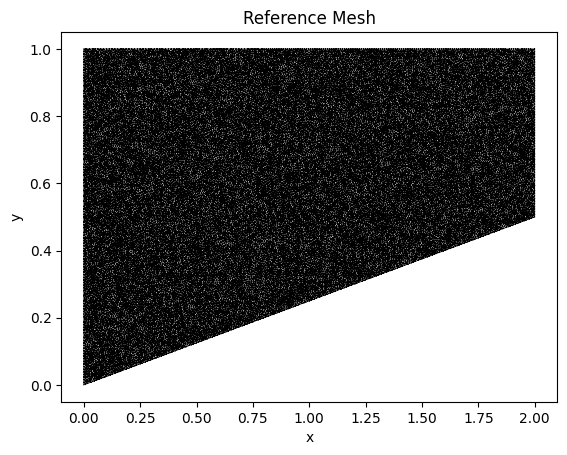

INFO: Reference solution generated with 58311 elements.


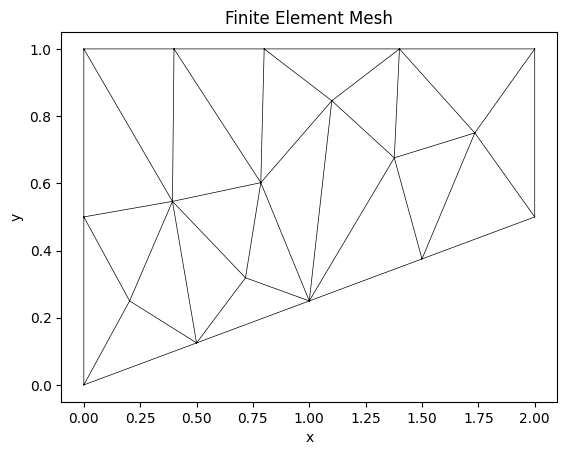

INFO: Initial global error = 3.115e-10, number of elements = 23
INFO: Iteration 0: Mean relative stress error = 1.102e+00, Elements = 23
INFO: Iteration 1: Mean relative stress error = 1.115e+00, Elements = 86
INFO: Iteration 2: Mean relative stress error = 1.131e+00, Elements = 302
INFO: Iteration 3: Mean relative stress error = 1.128e+00, Elements = 1020
INFO: Iteration 4: Mean relative stress error = 1.121e+00, Elements = 3080
INFO: Iteration 5: Mean relative stress error = 1.113e+00, Elements = 7599
INFO: Iteration 6: Mean relative stress error = 1.117e+00, Elements = 14927
INFO: Iteration 7: Mean relative stress error = 1.116e+00, Elements = 16474
INFO: Iteration 8: Mean relative stress error = 1.115e+00, Elements = 16486
INFO: Iteration 9: Mean relative stress error = 1.115e+00, Elements = 16486
INFO: Iteration 10: Mean relative stress error = 1.115e+00, Elements = 16486
INFO: Iteration 11: Mean relative stress error = 1.115e+00, Elements = 16486
INFO: Mesh refinement has stagnat

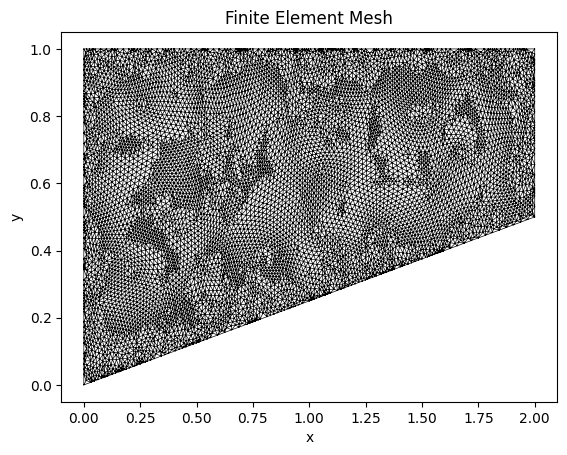

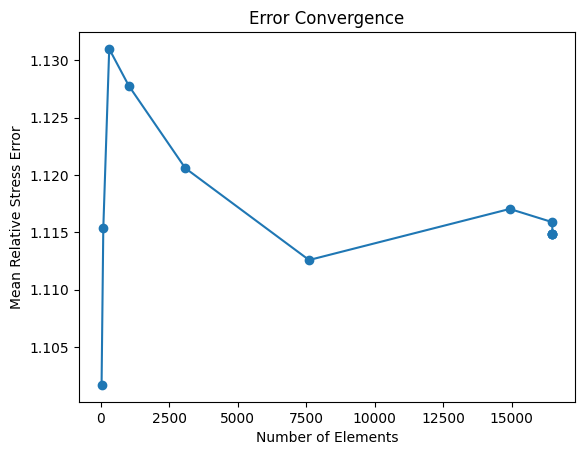

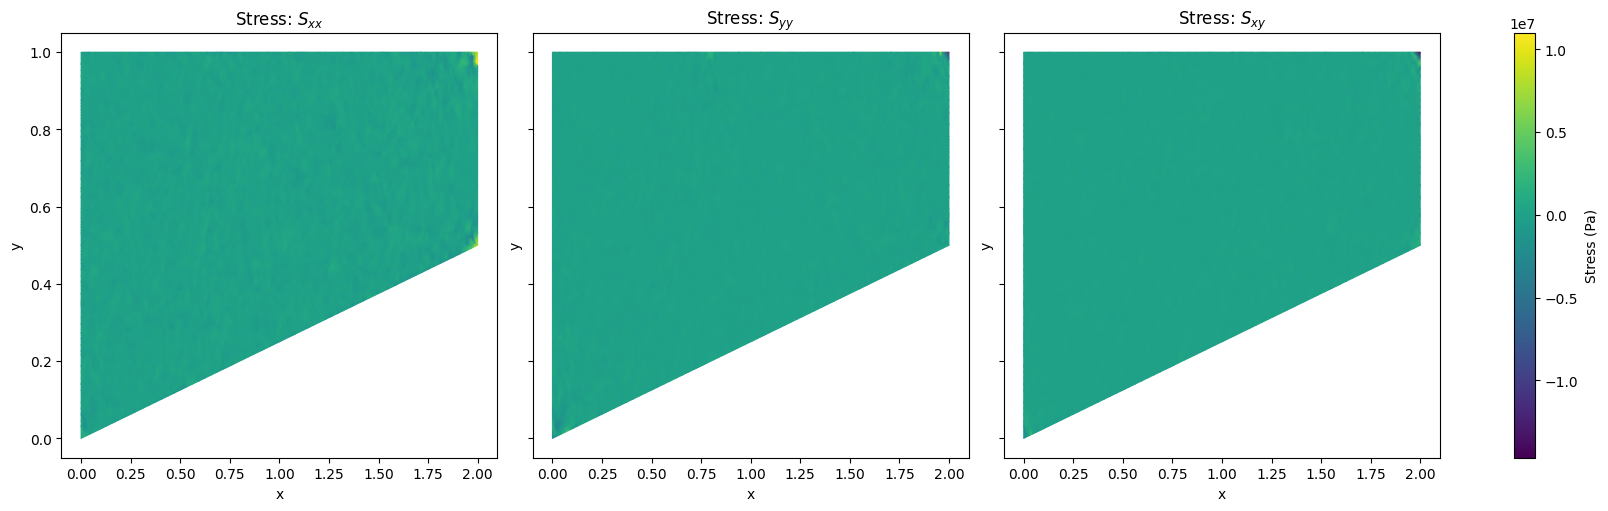

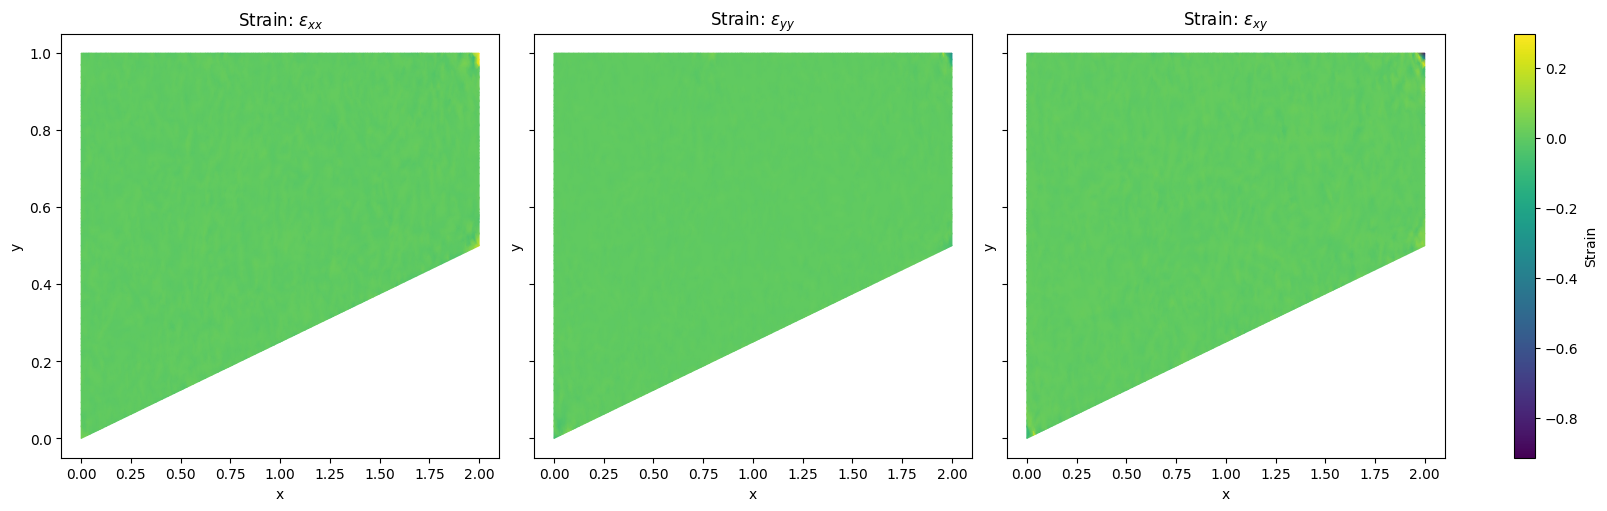

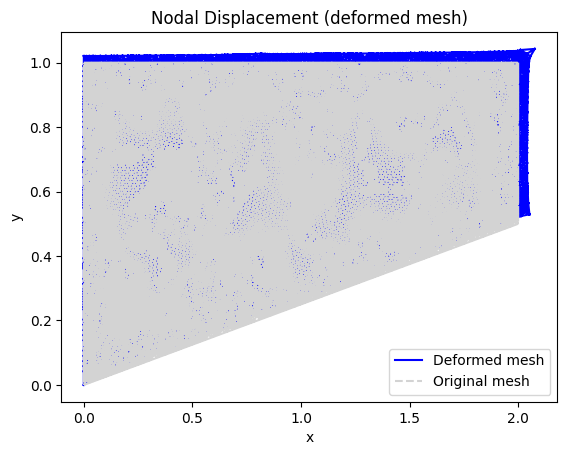

In [18]:
E = 4.4e7 # Pa
nu = 0.37
thickness = 0.08 # m
alpha = 0.8 # m

domain = Domain(
        vertices=np.array([
            [0.0, 0.0],
            [2.0, 0.5],
            [2.0, 1.0],
            [alpha, 1.0],
            [0.0, 1.0]]),
        
        edges=np.array([
            [0, 1],
            [1, 2],
            [2, 3],
            [3, 4],
            [4, 0]])
    )
    
tractions = {
    't1': { # Traction t1 (146,260) kPa acts on the edge between nodes 2 and 3.
        'traction'  :  np.array([146.0e3,260.0e3]), # Pa
        'nodes'     :   np.array([3,2])
        },
    
    't2' : {  # Traction t2 (1900,0) kPa acts on the edge between nodes 1 and 2.
        'traction'  :   np.array([1900.0e3,0.0]), #Pa
        'nodes'     :   np.array([1,2])
        }
    }

fe_solver = FiniteElement(mesh_type="triangular")

fe_solver._set_system_params(domain, E, nu, thickness, tractions=tractions, init_vol=0.1)

fe_solver.run_analysis(ref_max_volume=4e-5, tol_stress=0.01, max_iterations=20)

fe_solver.plot_data()